In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('train.csv')

In [3]:
print(df.columns)
print(df.shape)
print(df.info())

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
(891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


### 1. Setting Index

In [4]:
df.set_index(df['PassengerId'], inplace=True)

In [5]:
df.drop(columns='PassengerId', inplace=True)

### 2. Splitting into x_train and y_train

In [6]:
x_train = df.drop(columns='Survived')
y_train = df['Survived'].copy()

In [7]:
#Age, Cabin and Embarked have null values.
x_train.isna().sum()

Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

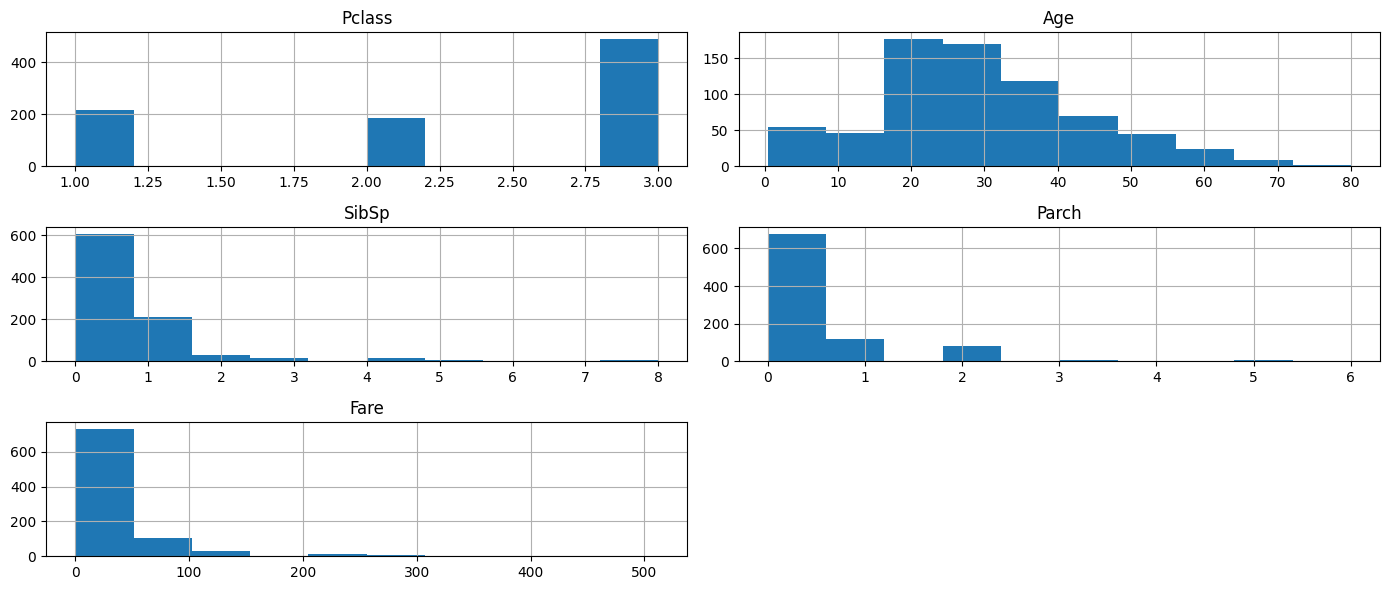

In [8]:
x_train.hist(figsize=(14,6))
plt.tight_layout()

- Name, Sex, Ticket, Cabin and Embarked are strings.
- Name is definitely irrelevant so we will remove it
- Ticket also seems irrelevant

### 3. Dropping Name Column and Ticket Column 

In [9]:
x_train.drop(columns='Name', inplace= True)

In [10]:
x_train.drop(columns='Ticket', inplace = True)

In [11]:
df.corr(numeric_only=True)['Survived']
# Clearly Pclass, and Fare are the most affecting, which also makes logical sense. But remember this only measures linear correlation

Survived    1.000000
Pclass     -0.338481
Age        -0.077221
SibSp      -0.035322
Parch       0.081629
Fare        0.257307
Name: Survived, dtype: float64

## Note:
- Cabin is unlikely to have a huge effect on Survival, but let's preprocess it just in case, maybe letters affect.

In [12]:
x_train[~x_train['Cabin'].isna()]

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,
2,1,female,38.0,1,0,71.2833,C85,C
4,1,female,35.0,1,0,53.1000,C123,S
7,1,male,54.0,0,0,51.8625,E46,S
11,3,female,4.0,1,1,16.7000,G6,S
12,1,female,58.0,0,0,26.5500,C103,S
...,...,...,...,...,...,...,...,...
872,1,female,47.0,1,1,52.5542,D35,S
873,1,male,33.0,0,0,5.0000,B51 B53 B55,S
880,1,female,56.0,0,1,83.1583,C50,C


In [13]:
x_train['Cabin'] = x_train['Cabin'].str[0]

In [14]:
x_train['Cabin'].value_counts()

Cabin
C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: count, dtype: int64

### Note:
- Since there's alot of null values in Cabin, then I'm gonna need to try the model once without Cabin at all, and once with categorical values of cabin, where NA is filled with some sort of normal distribution as the shown values.

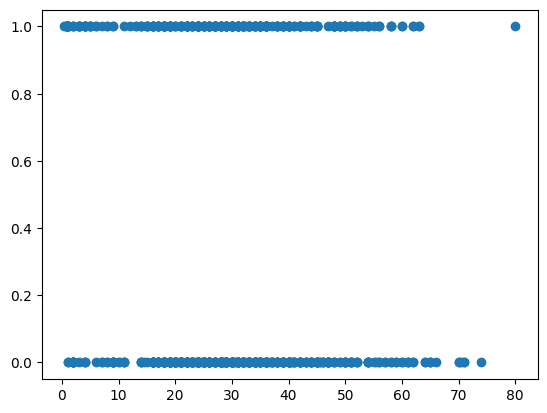

In [15]:
plt.scatter(x_train['Age'], y_train)

In [16]:
x_train['SibSp'].value_counts()

SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64

In [17]:
x_train.isna().sum()

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [18]:
x_train['Embarked'].value_counts(dropna=False)

Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

## Enough Playing. Here are the conclusions:
1. Pclass is a very important categorical feature.
2. Sex should be encoded into 0 and 1. Female = 0 Male = 1.
3. Age doesn't seem linearly that important. But has lots of missing values. Fill it with mean, and scale it.
4. SibSp has values from 0 -> 8. Doesn't seem that important. It's int anyway. Leave it as is.
5. Parch has values from 0 -> 6. Seems a little more important. It's int anyway. Leave it as is.
6. Fare is clearly important. It's numeric anyway. Scale it.
7. Cabin has ALOT of more missing values than not. Better to drop it.
8. Embarked has only 2 missing values. Fill with most frequent.



### 4. Dropping Cabin. Filling 2 missing values in Embarked. Filling Age with mean.

In [19]:
x_train.drop(columns='Cabin', inplace=True)

In [20]:
print(x_train['Embarked'].value_counts())
x_train['Embarked'] = x_train['Embarked'].fillna('S')
x_train['Embarked'].isna().any()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


np.False_

In [21]:
avg_age = round(x_train['Age'].mean())
x_train['Age'] = x_train['Age'].fillna(avg_age)
x_train.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

### 5. Encoding Sex and Embarked
- Female = 0, Male = 1

In [22]:
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder

col_transformer = make_column_transformer(
    (StandardScaler(), ['Age', 'Fare']),
    (OrdinalEncoder(), ['Sex', 'Embarked']),
    remainder='passthrough')

In [23]:
x_transformed = col_transformer.fit_transform(x_train)

In [24]:
x_transformed_df = pd.DataFrame(x_transformed, columns= col_transformer.get_feature_names_out(),
                                index = x_train.index)

In [25]:
x_transformed_df.columns.str.split('__').str[-1]

Index(['Age', 'Fare', 'Sex', 'Embarked', 'Pclass', 'SibSp', 'Parch'], dtype='object')

In [26]:
x_transformed_df.columns = x_transformed_df.columns.str.split('__').str[-1]

In [27]:
x_transformed_df

,Age,Fare,Sex,Embarked,Pclass,SibSp,Parch
PassengerId,,,,,,,
1,-0.597055,-0.502445,1.0,2.0,3.0,1.0,0.0
2,0.634162,0.786845,0.0,0.0,1.0,1.0,0.0
3,-0.289251,-0.488854,0.0,2.0,3.0,0.0,0.0
4,0.403309,0.420730,0.0,2.0,1.0,1.0,0.0
5,0.403309,-0.486337,1.0,2.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...
887,-0.212299,-0.386671,1.0,2.0,2.0,0.0,0.0
888,-0.827908,-0.044381,0.0,2.0,1.0,0.0,0.0
889,0.018554,-0.176263,0.0,2.0,3.0,1.0,2.0


### Now all my features are null free, scaled and numerical.
- Let's check correlation now
    - Conclusion > Sex and Embarked are now very clearly affecting the survival rate!

In [28]:
x_transformed_df.corrwith(y_train)

Age        -0.070657
Fare        0.257307
Sex        -0.543351
Embarked   -0.167675
Pclass     -0.338481
SibSp      -0.035322
Parch       0.081629
dtype: float64

## Time to test different models.
- LogisticRegression, Decision Trees, Random Forest, SVM

In [29]:
print(x_transformed_df.shape)
print(y_train.shape)

(891, 7)
(891,)


In [30]:
from sklearn.metrics import recall_score, f1_score, precision_score
from sklearn.model_selection import cross_val_score


### Decision Tree

In [31]:
from sklearn.tree import DecisionTreeClassifier

tree_clf= DecisionTreeClassifier()

precision_scores = cross_val_score(tree_clf, x_transformed_df, y_train, cv=5, scoring='precision')
recall_scores = cross_val_score(tree_clf, x_transformed_df, y_train, cv=5, scoring='recall')
f1_scores = cross_val_score(tree_clf, x_transformed_df, y_train, cv=5, scoring='f1')
print("Precision Scores:", precision_scores)
print("Recall Scores:", recall_scores)
print("F1 Scores:", f1_scores)

print("\nAvg Precision Scores:", precision_scores.mean())
print("Avg Recall Scores:", recall_scores.mean())
print("Avg F1 Scores:", f1_scores.mean())


Precision Scores: [0.67164179 0.67605634 0.74285714 0.68333333 0.76056338]
Recall Scores: [0.68115942 0.72058824 0.72058824 0.60294118 0.73913043]
F1 Scores: [0.68115942 0.69503546 0.72592593 0.640625   0.74647887]

Avg Precision Scores: 0.7068903971090222
Avg Recall Scores: 0.6928815004262574
Avg F1 Scores: 0.6978449360896251


### Random Forest

In [32]:
# Cross validation scores.
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

precision_scores = cross_val_score(rf_clf, x_transformed_df, y_train, cv=5, scoring='precision')
recall_scores = cross_val_score(rf_clf, x_transformed_df, y_train, cv=5, scoring='recall')
f1_scores = cross_val_score(rf_clf, x_transformed_df, y_train, cv=5, scoring='f1')
print("Precision Scores:", precision_scores)
print("Recall Scores:", recall_scores)
print("F1 Scores:", f1_scores)

print("\nAvg Precision Scores:", precision_scores.mean())
print("Avg Recall Scores:", recall_scores.mean())
print("Avg F1 Scores:", f1_scores.mean())


Precision Scores: [0.69444444 0.76190476 0.83606557 0.73214286 0.78082192]
Recall Scores: [0.69565217 0.70588235 0.77941176 0.63235294 0.8115942 ]
F1 Scores: [0.71942446 0.73282443 0.8030303  0.68852459 0.80851064]

Avg Precision Scores: 0.761075911014155
Avg Recall Scores: 0.7249786871270247
Avg F1 Scores: 0.7504628838809361


### SVM Classifier

In [33]:
from sklearn.svm import SVC

sv_clf = SVC()

precision_scores = cross_val_score(sv_clf, x_transformed_df, y_train, cv=5, scoring='precision')
recall_scores = cross_val_score(sv_clf, x_transformed_df, y_train, cv=5, scoring='recall')
f1_scores = cross_val_score(sv_clf, x_transformed_df, y_train, cv=5, scoring='f1')
print("Precision Scores:", precision_scores)
print("Recall Scores:", recall_scores)
print("F1 Scores:", f1_scores)

print("\nAvg Precision Scores:", precision_scores.mean())
print("Avg Recall Scores:", recall_scores.mean())
print("Avg F1 Scores:", f1_scores.mean())


Precision Scores: [0.78787879 0.78461538 0.76190476 0.84       0.85      ]
Recall Scores: [0.75362319 0.75       0.70588235 0.61764706 0.73913043]
F1 Scores: [0.77037037 0.76691729 0.73282443 0.71186441 0.79069767]

Avg Precision Scores: 0.8048797868797868
Avg Recall Scores: 0.7132566069906223
Avg F1 Scores: 0.7545348344565269


### SGD Classifier

In [34]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()

precision_scores = cross_val_score(sgd_clf, x_transformed_df, y_train, cv=5, scoring='precision')
recall_scores = cross_val_score(sgd_clf, x_transformed_df, y_train, cv=5, scoring='recall')
f1_scores = cross_val_score(sgd_clf, x_transformed_df, y_train, cv=5, scoring='f1')
print("Precision Scores:", precision_scores)
print("Recall Scores:", recall_scores)
print("F1 Scores:", f1_scores)

print("\nAvg Precision Scores:", precision_scores.mean())
print("Avg Recall Scores:", recall_scores.mean())
print("Avg F1 Scores:", f1_scores.mean())


Precision Scores: [0.71014493 0.6835443  0.79411765 0.69014085 0.77777778]
Recall Scores: [0.52173913 0.72058824 0.36764706 0.54411765 0.73913043]
F1 Scores: [0.58119658 0.73202614 0.55510204 0.67241379 0.65079365]

Avg Precision Scores: 0.7311451002481448
Avg Recall Scores: 0.5786445012787723
Avg F1 Scores: 0.6383064419401713


### SVM Classifier `SVC()` works best. An ensemble of SVC and RandomForest would probably work even better. Will try later. For now, make a final model of SVC.
<hr>

In [74]:
df_test = pd.read_csv('test.csv')

In [75]:
x_test = df_test.set_index('PassengerId')

In [76]:
x_test.drop(columns='Name', inplace= True)
x_test.drop(columns='Ticket', inplace = True)
x_test.drop(columns='Cabin', inplace=True)

In [77]:
print(x_test['Embarked'].value_counts())
x_test['Embarked'] = x_test['Embarked'].fillna('S')
x_test['Embarked'].isna().any()

Embarked
S    270
C    102
Q     46
Name: count, dtype: int64


np.False_

In [78]:
avg_age_t = round(x_test['Age'].mean())
x_test['Age'] = x_test['Age'].fillna(avg_age_t)
x_test.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        1
Embarked    0
dtype: int64

In [82]:
x_test['Fare'] = x_test['Fare'].fillna(x_test['Fare'].mean())

In [84]:
x_test_transformed = col_transformer.transform(x_test)

In [85]:
sv_clf.fit(x_transformed, y_train)

SVC()

In [86]:
x_test_transformed_df = pd.DataFrame(x_test_transformed, columns = col_transformer.get_feature_names_out(),
                                     index = x_test.index)

In [87]:
y_pred = sv_clf.predict(x_test_transformed_df)

c:\Users\Dell\miniconda3\envs\workshop_env\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [90]:
x_test.index

Index([ 892,  893,  894,  895,  896,  897,  898,  899,  900,  901,
       ...
       1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309],
      dtype='int64', name='PassengerId', length=418)

In [107]:
y_pred_df = pd.DataFrame(y_pred, index = x_test.index,
                         columns= ['Survived'])

In [ ]:
y_pred_df

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [109]:
mySubmission = y_pred_df.to_csv('mySubmissionV1.csv')

# Score on Kaggle is 0.7751 for the above pipeline. Can definitely do better with ensemble.